# Computing year-over-year, sales revenue weighted WAC price percent changes for each drug per month

In [1]:
# Importing basic libraries
import pandas as pd
import numpy as np
import time
import datetime

# Plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(12,10)})
plt.style.use('fivethirtyeight')
from tqdm import tqdm

### Loading the clean dataset

In [5]:
# Loading the dataset
df = pd.read_csv('drugs_pct_changes_monthly.csv')

print("Shape: ", df.shape)
df.head()

Shape:  (242939, 19)


,NDC,Manufacturer,Product,Product Launch Date,Estimated LOE Date,Major Class,Acute/Chronic,Prod Form,Pack Size,Pack Quantity,Date,Year,Month,TRx,Previous_TRx,TRx_cumulative,WAC,Pct_change,Changed
0,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2014_10,2014,10,0,NaN,0.0,244.16,NaN,0
1,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2014_11,2014,11,6,0.0,6.0,244.16,0.0,0
2,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2014_12,2014,12,22,6.0,28.0,244.16,0.0,0
3,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2015_01,2015,1,21,22.0,21.0,244.16,0.0,0
4,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2015_02,2015,2,15,21.0,36.0,244.16,0.0,0


### 0. Example of sort needed to calculate year-over-year percent change

In [7]:
df_yy_test = df[df.NDC == 2143301].sort_values(['Month', 'Year']).reset_index(drop=True)
df_yy_test.head(10)

,NDC,Manufacturer,Product,Product Launch Date,Estimated LOE Date,Major Class,Acute/Chronic,Prod Form,Pack Size,Pack Quantity,Date,Year,Month,TRx,Previous_TRx,TRx_cumulative,WAC,Pct_change,Changed
0,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2015_01,2015,1,21,22.0,21.0,244.16,0.0,0
1,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2016_01,2016,1,110,79.0,110.0,287.40,0.0,0
2,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2017_01,2017,1,132,125.0,132.0,313.00,0.0,0
3,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2018_01,2018,1,259,240.0,259.0,338.00,0.0,0
4,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2019_01,2019,1,459,492.0,459.0,365.10,0.0,0
5,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2020_01,2020,1,671,613.0,671.0,379.70,0.0,0
6,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2015_02,2015,2,15,21.0,36.0,244.16,0.0,0
7,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2016_02,2016,2,102,110.0,212.0,287.40,0.0,0
8,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2017_02,2017,2,144,132.0,276.0,313.00,0.0,0
9,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2018_02,2018,2,228,259.0,487.0,338.00,0.0,0


### 1. Example of calculating year-of-year percent change for 2 drugs

In [9]:
# Sorting values
df_yy = df.sort_values(['Month', 'Year'])

# List of unique NDCs. Just 2 for now to make sure loops/code works
NDCs = [2143301,89122049663]

# Empty Dataframe to store new concat. data
df_pct_yy_test = pd.DataFrame(columns=df.columns)
df_pct_yy_test['Pct_change_y/y'] = None 

# Empty Dataframe to store new data for NDC level calculations
df_pct_yy_m_test = pd.DataFrame(columns=df_yy.columns)
df_pct_yy_m_test['Pct_change_y/y'] = None 

# For each drug, compute pct change and append to dataframe
for NDC in tqdm(NDCs):
    df_temp1 = df_yy[df_yy.NDC == NDC].copy()
    
    for num in range(1, 13):
        df_temp2 = df_temp1[df_temp1.Month == num].copy()
        df_temp2['Pct_change_y/y'] = df_temp2.WAC.pct_change()
        df_pct_yy_m_test = pd.concat((df_pct_yy_m_test, df_temp2))
        print("step 1")
       
    df_pct_yy_test = pd.concat((df_pct_yy_test, df_pct_yy_m_test))
    df_pct_yy_m_test = pd.DataFrame(columns=df_yy.columns)
    df_pct_yy_m_test['Pct_change_y/y'] = None 
    print("step 2")

print("Shape: ", df_pct_yy_test.shape)
df_pct_yy_test.head(10)

  0%|          | 0/2 [00:00<?, ?it/s]

step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 2


 50%|█████     | 1/2 [00:00<00:00,  3.86it/s]

step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 2


100%|██████████| 2/2 [00:00<00:00,  3.87it/s]


Shape:  (92, 20)


,NDC,Manufacturer,Product,Product Launch Date,Estimated LOE Date,Major Class,Acute/Chronic,Prod Form,Pack Size,Pack Quantity,Date,Year,Month,TRx,Previous_TRx,TRx_cumulative,WAC,Pct_change,Changed,Pct_change_y/y
3,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2015_01,2015,1,21,22.0,21.0,244.16,0.0,0,NaN
15,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2016_01,2016,1,110,79.0,110.0,287.40,0.0,0,0.177097
27,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2017_01,2017,1,132,125.0,132.0,313.00,0.0,0,0.089074
39,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2018_01,2018,1,259,240.0,259.0,338.00,0.0,0,0.079872
51,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2019_01,2019,1,459,492.0,459.0,365.10,0.0,0,0.080178
63,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2020_01,2020,1,671,613.0,671.0,379.70,0.0,0,0.039989
4,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2015_02,2015,2,15,21.0,36.0,244.16,0.0,0,NaN
16,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2016_02,2016,2,102,110.0,212.0,287.40,0.0,0,0.177097
28,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2017_02,2017,2,144,132.0,276.0,313.00,0.0,0,0.089074
40,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2018_02,2018,2,228,259.0,487.0,338.00,0.0,0,0.079872


### 2. Year-of-Year Percent Change for all NDCs (WARNING TAKES 30 MINUTES TO RUN)

In [10]:
# Sorting values
df_yy = df.sort_values(['Month', 'Year'])

# List of unique NDCs 
NDCs = df.NDC.unique()

# Empty Dataframe to store new concat. data
df_pct_yy = pd.DataFrame(columns=df.columns)
df_pct_yy['Pct_change_y/y'] = None 

# Empty Dataframe to store new data for NDC level calculations
df_pct_yy_m = pd.DataFrame(columns=df_yy.columns)
df_pct_yy_m['Pct_change_y/y'] = None 

# For each drug, compute pct change and append to dataframe
for NDC in tqdm(NDCs):
    df_temp1 = df_yy[df_yy.NDC == NDC].copy()
    
    for num in range(1, 13):
        df_temp2 = df_temp1[df_temp1.Month == num].copy()
        df_temp2['Pct_change_y/y'] = df_temp2.WAC.pct_change()
        df_pct_yy_m = pd.concat((df_pct_yy_m, df_temp2))
       
    df_pct_yy = pd.concat((df_pct_yy, df_pct_yy_m))
    df_pct_yy_m = pd.DataFrame(columns=df_yy.columns)
    df_pct_yy_m['Pct_change_y/y'] = None

print("Shape: ", df_pct_yy.shape)
df_pct_yy.head()

100%|██████████| 4633/4633 [32:37<00:00,  1.76it/s]


Shape:  (242939, 20)


,NDC,Manufacturer,Product,Product Launch Date,Estimated LOE Date,Major Class,Acute/Chronic,Prod Form,Pack Size,Pack Quantity,Date,Year,Month,TRx,Previous_TRx,TRx_cumulative,WAC,Pct_change,Changed,Pct_change_y/y
3,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2015_01,2015,1,21,22.0,21.0,244.16,0.0,0,NaN
15,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2016_01,2016,1,110,79.0,110.0,287.40,0.0,0,0.177097
27,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2017_01,2017,1,132,125.0,132.0,313.00,0.0,0,0.089074
39,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2018_01,2018,1,259,240.0,259.0,338.00,0.0,0,0.079872
51,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,2019_01,2019,1,459,492.0,459.0,365.10,0.0,0,0.080178


### 3. Revenue Weighted, Year-Over-Year WAC Percent Change for Industry

In [11]:
#Calculating monthly sales revenue per drug: WAC Price * TRx volume
df_pct_yy['Revenue'] = df_pct_yy['WAC'] * df_pct_yy['TRx'] 

In [12]:
#Calculating total monthly sales revenue for all drugs
df_pct_yy['Total_revenue'] = df_pct_yy.groupby('Date')['Revenue'].transform('sum')

In [13]:
#Calculating Revenue Weighted Percent Change: need to sum up monthly % changes to see drug market trends
df_pct_yy['Wght_pct_change_y/y'] = df_pct_yy['Pct_change_y/y'] * (df_pct_yy['Revenue'] / df_pct_yy['Total_revenue'])
df_pct_yy.head()


,NDC,Manufacturer,Product,Product Launch Date,Estimated LOE Date,Major Class,Acute/Chronic,Prod Form,Pack Size,Pack Quantity,...,TRx,Previous_TRx,TRx_cumulative,WAC,Pct_change,Changed,Pct_change_y/y,Revenue,Total_revenue,Wght_pct_change_y/y
3,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,...,21,22.0,21.0,244.16,0.0,0,NaN,5127.36,1.913754e+09,NaN
15,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,...,110,79.0,110.0,287.40,0.0,0,0.177097,31614,2.321833e+09,2.41135e-06
27,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,...,132,125.0,132.0,313.00,0.0,0,0.089074,41316,2.773950e+09,1.3267e-06
39,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,...,259,240.0,259.0,338.00,0.0,0,0.079872,87542,3.405939e+09,2.05294e-06
51,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,...,459,492.0,459.0,365.10,0.0,0,0.080178,167581,4.201433e+09,3.19801e-06


In [ ]:
# Saving dataset
df_pct_yy.to_csv('yearoveryear_WAC_pct_changes_RevWeighted_monthly.csv', index=False)

In [2]:
# Reloading the dataset so can skip the 30 minute data processing
df_pct_yy = pd.read_csv('yearoveryear_WAC_pct_changes_RevWeighted_monthly.csv')

print("Shape: ", df_pct_yy.shape)
df_pct_yy.head()

Shape:  (242939, 23)


,NDC,Manufacturer,Product,Product Launch Date,Estimated LOE Date,Major Class,Acute/Chronic,Prod Form,Pack Size,Pack Quantity,...,TRx,Previous_TRx,TRx_cumulative,WAC,Pct_change,Changed,Pct_change_y/y,Revenue,Total_revenue,Wght_pct_change_y/y
0,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,...,21,22.0,21.0,244.16,0.0,0,NaN,5127.36,1.913754e+09,NaN
1,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,...,110,79.0,110.0,287.40,0.0,0,0.177097,31614.00,2.321833e+09,0.000002
2,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,...,132,125.0,132.0,313.00,0.0,0,0.089074,41316.00,2.773950e+09,0.000001
3,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,...,259,240.0,259.0,338.00,0.0,0,0.079872,87542.00,3.405939e+09,0.000002
4,2143301,Eli Lilly and Co,TRULICITY 10/2014 LLY,10/1/2014 0:00,Sep-26,ANTIDIABETICS,CHRONIC,INJECTABLES,1,0.5,...,459,492.0,459.0,365.10,0.0,0,0.080178,167580.90,4.201433e+09,0.000003


### 4. Year-Over-Year, Revenue Weighted WAC % Change for Entire Market Table

In [3]:
#Revenue Weighted, Year-over-year WAC percent change for entire market
df_yearoveryear_market = df_pct_yy.groupby('Date')['Wght_pct_change_y/y'].sum().reset_index()

In [4]:
df_yearoveryear_market.head()

,Date,Wght_pct_change_y/y
0,2014_08,0.0
1,2014_09,0.0
2,2014_10,0.0
3,2014_11,0.0
4,2014_12,0.0


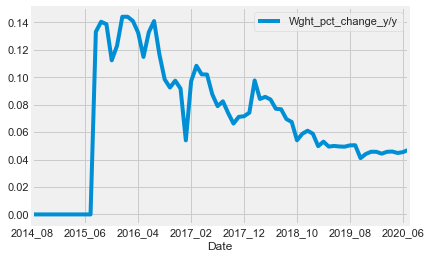

In [5]:
#Graphing weighted average WAC percent change
df_yearoveryear_market.plot(x='Date', y='Wght_pct_change_y/y')

### 5. Revenue Weighted, Year-Over-Year WAC Percent Change by Major Class

In [12]:
# Reload data if needed
df_pct_yy = pd.read_csv('yearoveryear_WAC_pct_changes_RevWeighted_monthly.csv')

In [13]:
#Calculating total revenue for EACH MAJOR CLASS for each month
df_pct_yy['Class_revenue'] = df_pct_yy.groupby(['Date','Major Class'])['Revenue'].transform('sum')

In [14]:
df_pct_yy_class = df_pct_yy.sort_values('Class_revenue')
print("Shape: ", df_pct_yy_class.shape)
df_pct_yy_class.head()

Shape:  (242939, 24)


,NDC,Manufacturer,Product,Product Launch Date,Estimated LOE Date,Major Class,Acute/Chronic,Prod Form,Pack Size,Pack Quantity,...,Previous_TRx,TRx_cumulative,WAC,Pct_change,Changed,Pct_change_y/y,Revenue,Total_revenue,Wght_pct_change_y/y,Class_revenue
152797,45043000102,Manchester Pharmaceuticals Inc a subsidiary of...,CHOLBAM MA3,Unspecified,Unspecified,A05A1 CHOLERETICS+CHOLEKINETIC,ACUTE,ORALS,1,90.0,...,1.0,11.0,275.83333,0.0,0,0.0,0.0,4.750096e+09,0.0,0.0
113166,270055615,Bracco Diagnostics Inc,KINEVAC 10/1982 BCD,10/1/1982 0:00,Unspecified,IMAGING,ACUTE,INJECTABLES,10,1.0,...,0.0,0.0,68.63100,0.0,0,NaN,0.0,1.855033e+09,NaN,0.0
113165,270055615,Bracco Diagnostics Inc,KINEVAC 10/1982 BCD,10/1/1982 0:00,Unspecified,IMAGING,ACUTE,INJECTABLES,10,1.0,...,0.0,0.0,68.63100,0.0,0,0.0,0.0,4.601280e+09,0.0,0.0
113164,270055615,Bracco Diagnostics Inc,KINEVAC 10/1982 BCD,10/1/1982 0:00,Unspecified,IMAGING,ACUTE,INJECTABLES,10,1.0,...,0.0,0.0,68.63100,0.0,0,0.0,0.0,3.845556e+09,0.0,0.0
113162,270055615,Bracco Diagnostics Inc,KINEVAC 10/1982 BCD,10/1/1982 0:00,Unspecified,IMAGING,ACUTE,INJECTABLES,10,1.0,...,0.0,10.0,68.63100,0.0,0,0.0,0.0,3.005864e+09,0.0,0.0


In [15]:
# Trim rows with class revenue of zero
df_pct_yy_class_2 = df_pct_yy_class[df_pct_yy_class['Class_revenue']>0]
# Trim rows with Pct_change_y/y of NaN
df_pct_yy_class_2 = df_pct_yy_class_2[df_pct_yy_class_2['Pct_change_y/y'].notna()]
print("Shape: ", df_pct_yy_class_2.shape)
df_pct_yy_class_2.head()

Shape:  (188698, 24)


,NDC,Manufacturer,Product,Product Launch Date,Estimated LOE Date,Major Class,Acute/Chronic,Prod Form,Pack Size,Pack Quantity,...,Previous_TRx,TRx_cumulative,WAC,Pct_change,Changed,Pct_change_y/y,Revenue,Total_revenue,Wght_pct_change_y/y,Class_revenue
211202,63323024120,Fresenius Kabi USA LLC,GLYCOPHOS 06/2013 FK2,6/1/2013 0:00,Unspecified,HOSPITAL SOLUTIONS,ACUTE,INJECTABLES,10,20.0,...,0.0,0.0,0.5500,0.0,0,0.0,0.0000,2.700530e+09,0.0,8.0000
211135,63323014397,Fresenius Kabi USA LLC,ADDAMEL N 06/2013 FK2,6/1/2013 0:00,Unspecified,HOSPITAL SOLUTIONS,ACUTE,INJECTABLES,20,10.0,...,17.0,57.0,1.6000,0.0,0,0.0,8.0000,2.700530e+09,0.0,8.0000
211165,63323014397,Fresenius Kabi USA LLC,ADDAMEL N 06/2013 FK2,6/1/2013 0:00,Unspecified,HOSPITAL SOLUTIONS,ACUTE,INJECTABLES,20,10.0,...,14.0,130.0,1.6000,0.0,0,0.0,8.0000,3.005864e+09,0.0,8.0000
211220,63323024120,Fresenius Kabi USA LLC,GLYCOPHOS 06/2013 FK2,6/1/2013 0:00,Unspecified,HOSPITAL SOLUTIONS,ACUTE,INJECTABLES,10,20.0,...,0.0,0.0,0.5500,0.0,0,0.0,0.0000,3.005864e+09,0.0,8.0000
82460,78059061,Novartis Pharmaceuticals Corporation,ZOMETA 09/2001 NVR,9/1/2001 0:00,Mar-13,BISPHOSPHONATES TUMOR-RELATED & BONY METASTASES,CHRONIC,INJECTABLES,1,100.0,...,2.0,19.0,9.2248,0.0,0,0.0,9.2248,4.497007e+09,0.0,9.2248


In [16]:
#Calculating MAJOR CLASS Weighted Percent Change
df_pct_yy_class_2['Class_wght_pct_change_y/y'] = df_pct_yy_class_2['Pct_change_y/y'] * (df_pct_yy_class_2['Revenue'] / df_pct_yy_class_2['Class_revenue'])
df_pct_yy_class_2.head()

,NDC,Manufacturer,Product,Product Launch Date,Estimated LOE Date,Major Class,Acute/Chronic,Prod Form,Pack Size,Pack Quantity,...,TRx_cumulative,WAC,Pct_change,Changed,Pct_change_y/y,Revenue,Total_revenue,Wght_pct_change_y/y,Class_revenue,Class_wght_pct_change_y/y
211202,63323024120,Fresenius Kabi USA LLC,GLYCOPHOS 06/2013 FK2,6/1/2013 0:00,Unspecified,HOSPITAL SOLUTIONS,ACUTE,INJECTABLES,10,20.0,...,0.0,0.5500,0.0,0,0.0,0.0000,2.700530e+09,0.0,8.0000,0.0
211135,63323014397,Fresenius Kabi USA LLC,ADDAMEL N 06/2013 FK2,6/1/2013 0:00,Unspecified,HOSPITAL SOLUTIONS,ACUTE,INJECTABLES,20,10.0,...,57.0,1.6000,0.0,0,0.0,8.0000,2.700530e+09,0.0,8.0000,0.0
211165,63323014397,Fresenius Kabi USA LLC,ADDAMEL N 06/2013 FK2,6/1/2013 0:00,Unspecified,HOSPITAL SOLUTIONS,ACUTE,INJECTABLES,20,10.0,...,130.0,1.6000,0.0,0,0.0,8.0000,3.005864e+09,0.0,8.0000,0.0
211220,63323024120,Fresenius Kabi USA LLC,GLYCOPHOS 06/2013 FK2,6/1/2013 0:00,Unspecified,HOSPITAL SOLUTIONS,ACUTE,INJECTABLES,10,20.0,...,0.0,0.5500,0.0,0,0.0,0.0000,3.005864e+09,0.0,8.0000,0.0
82460,78059061,Novartis Pharmaceuticals Corporation,ZOMETA 09/2001 NVR,9/1/2001 0:00,Mar-13,BISPHOSPHONATES TUMOR-RELATED & BONY METASTASES,CHRONIC,INJECTABLES,1,100.0,...,19.0,9.2248,0.0,0,0.0,9.2248,4.497007e+09,0.0,9.2248,0.0


In [17]:
#MAJOR CLASS Revenue Weighted, Year-over-year WAC percent change
df_yearoveryear_class = df_pct_yy_class_2.groupby(['Date','Major Class'])['Class_wght_pct_change_y/y'].sum().reset_index()

In [18]:
df_yearoveryear_class.tail()

,Date,Major Class,Class_wght_pct_change_y/y
4290,2020_07,THYROID ANTI-THYROID AND IODINE PREPS,0.045537
4291,2020_07,URINARY INCONTINENCE,0.052705
4292,2020_07,"VACCINES (PURE, COMB, OTHER)",0.050210
4293,2020_07,VIRAL HEPATITIS,0.006717
4294,2020_07,VITAMINS & MINERALS,0.000000


In [19]:
# pivot table of drug classes to do correlation
pivot_yearover_year_class = pd.pivot_table(df_yearoveryear_class, index = 'Date', columns = 'Major Class', values = 'Class_wght_pct_change_y/y') 
pivot_yearover_year_class = pivot_yearover_year_class.sort_values('Date')
pivot_yearover_year_class.tail()


Major Class,A.C.T.H.,A05A1 CHOLERETICS+CHOLEKINETIC,ADHD,ALL OTHER RESPIRATORY,ALL OTHER THERAPEUTICS,ALL OTHER UROLOGICAL,"ALLERGY, SYSTEMIC & NASAL",ANTI-ALZHEIMERS,"ANTI-ANAEMICS, IRON AND ALL COMBINATIONS",ANTI-INFLAMMATORY AND DIGESTIVE ENZYMES AND MODULA,...,RESPIRATORY AGENTS,"SEX HORMONES (ANDROGENS, OESTROGENS, PROGESTOGENS,",SPEC IMMUNOGLOBULINS & ANTITOXIC SERA,SYST ANTIFUNGALS,THROMBOPOIETIN AGONISTS,THYROID ANTI-THYROID AND IODINE PREPS,URINARY INCONTINENCE,"VACCINES (PURE, COMB, OTHER)",VIRAL HEPATITIS,VITAMINS & MINERALS
Date,,,,,,,,,,,,,,,,,,,,,
2020_03,0.024992,0.0,0.073563,0.024299,0.021479,0.019625,0.013564,0.038113,0.004694,0.073997,...,0.030633,0.057834,NaN,-0.000174,0.059903,0.045181,0.052084,0.046203,0.009203,0.0
2020_04,0.024992,0.0,0.073967,0.026057,0.021528,0.022490,0.013836,0.038543,0.002616,0.073996,...,0.030485,0.074002,NaN,-0.000195,0.061224,0.045011,0.052340,0.049282,0.010335,0.0
2020_05,0.024992,0.0,0.046510,0.025689,0.057448,0.022923,0.010838,0.038348,0.001422,0.073996,...,0.030585,0.069323,0.0,-0.000349,0.060898,0.045156,0.052484,0.049178,0.006285,0.0
2020_06,0.024992,0.0,0.046590,0.025339,0.058198,0.022651,0.008209,0.038261,0.001190,0.073998,...,0.030283,0.068392,0.0,-0.000462,0.060805,0.045458,0.052545,0.049665,0.006481,0.0
2020_07,0.024992,0.0,0.046661,0.025802,0.058315,0.019795,0.006431,0.038298,0.000859,0.074000,...,0.029971,0.067551,0.0,-0.000473,0.060022,0.045537,0.052705,0.050210,0.006717,0.0


In [20]:
pivot_yearover_year_class.head()
print("Shape: ", pivot_yearover_year_class.shape)


Shape:  (60, 75)


In [21]:
# Computing correlation matrix between the different classes based on:
# Year-over-year, revenue weighted % change
# Pandas will ignore NaN
yy_class_corr = pivot_yearover_year_class.corr()
yy_class_corr.head()

Major Class,A.C.T.H.,A05A1 CHOLERETICS+CHOLEKINETIC,ADHD,ALL OTHER RESPIRATORY,ALL OTHER THERAPEUTICS,ALL OTHER UROLOGICAL,"ALLERGY, SYSTEMIC & NASAL",ANTI-ALZHEIMERS,"ANTI-ANAEMICS, IRON AND ALL COMBINATIONS",ANTI-INFLAMMATORY AND DIGESTIVE ENZYMES AND MODULA,...,RESPIRATORY AGENTS,"SEX HORMONES (ANDROGENS, OESTROGENS, PROGESTOGENS,",SPEC IMMUNOGLOBULINS & ANTITOXIC SERA,SYST ANTIFUNGALS,THROMBOPOIETIN AGONISTS,THYROID ANTI-THYROID AND IODINE PREPS,URINARY INCONTINENCE,"VACCINES (PURE, COMB, OTHER)",VIRAL HEPATITIS,VITAMINS & MINERALS
Major Class,,,,,,,,,,,,,,,,,,,,,
A.C.T.H.,1.000000,NaN,0.445874,-0.531866,0.224623,0.228726,0.732533,0.274342,-0.030944,-0.001367,...,0.478679,0.630723,NaN,0.459080,0.613664,0.059768,0.194357,0.191313,0.078887,-0.320587
A05A1 CHOLERETICS+CHOLEKINETIC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADHD,0.445874,NaN,1.000000,-0.441266,0.782349,0.766810,0.449326,0.621244,-0.300747,-0.202907,...,0.775993,0.655162,NaN,0.607906,0.165576,0.812531,0.666628,0.467247,-0.081079,-0.092859
ALL OTHER RESPIRATORY,-0.531866,NaN,-0.441266,1.000000,-0.274772,-0.119886,-0.353569,-0.348680,0.442464,-0.054194,...,-0.238894,-0.675636,NaN,-0.325955,-0.341558,-0.279792,-0.446347,-0.328101,0.022082,0.623415
ALL OTHER THERAPEUTICS,0.224623,NaN,0.782349,-0.274772,1.000000,0.660984,0.375807,0.542183,-0.357703,-0.132127,...,0.597294,0.593979,NaN,0.561394,0.034179,0.583192,0.675467,0.353060,-0.322530,-0.036139


In [22]:
# Formating the correlation matrix to make it easier for Tableau analysis
yy_class_corr_format = yy_class_corr.stack().to_frame().reset_index(level=1).rename(columns={'Major Class': 'column', 0: 'corr'}).reset_index().rename(columns={'Major Class': 'row'})
yy_class_corr_format

# Saving csv file
# yy_class_corr_format.to_csv('yy_class_corr.csv')

,row,column,corr
0,A.C.T.H.,A.C.T.H.,1.000000
1,A.C.T.H.,ADHD,0.445874
2,A.C.T.H.,ALL OTHER RESPIRATORY,-0.531866
3,A.C.T.H.,ALL OTHER THERAPEUTICS,0.224623
4,A.C.T.H.,ALL OTHER UROLOGICAL,0.228726
5,A.C.T.H.,"ALLERGY, SYSTEMIC & NASAL",0.732533
6,A.C.T.H.,ANTI-ALZHEIMERS,0.274342
7,A.C.T.H.,"ANTI-ANAEMICS, IRON AND ALL COMBINATIONS",-0.030944
8,A.C.T.H.,ANTI-INFLAMMATORY AND DIGESTIVE ENZYMES AND MO...,-0.001367
9,A.C.T.H.,"ANTI-OBESITY PREPS, EXCL. DIETETICS",-0.506070


In [ ]:
# plotting correlation matrix
plt.subplots(figsize=(24,18))
sns.heatmap(trx_corr, annot=False, cmap=sns.diverging_palette(10, 220, as_cmap=True), vmin = -1, vmax = 1, center = 0)
# plt.savefig('TRx_correlations_Major_class_noCovid.jpg', bbox_inches='tight', pad_inches=2)
plt.title('Volume Correlations')
plt.show()

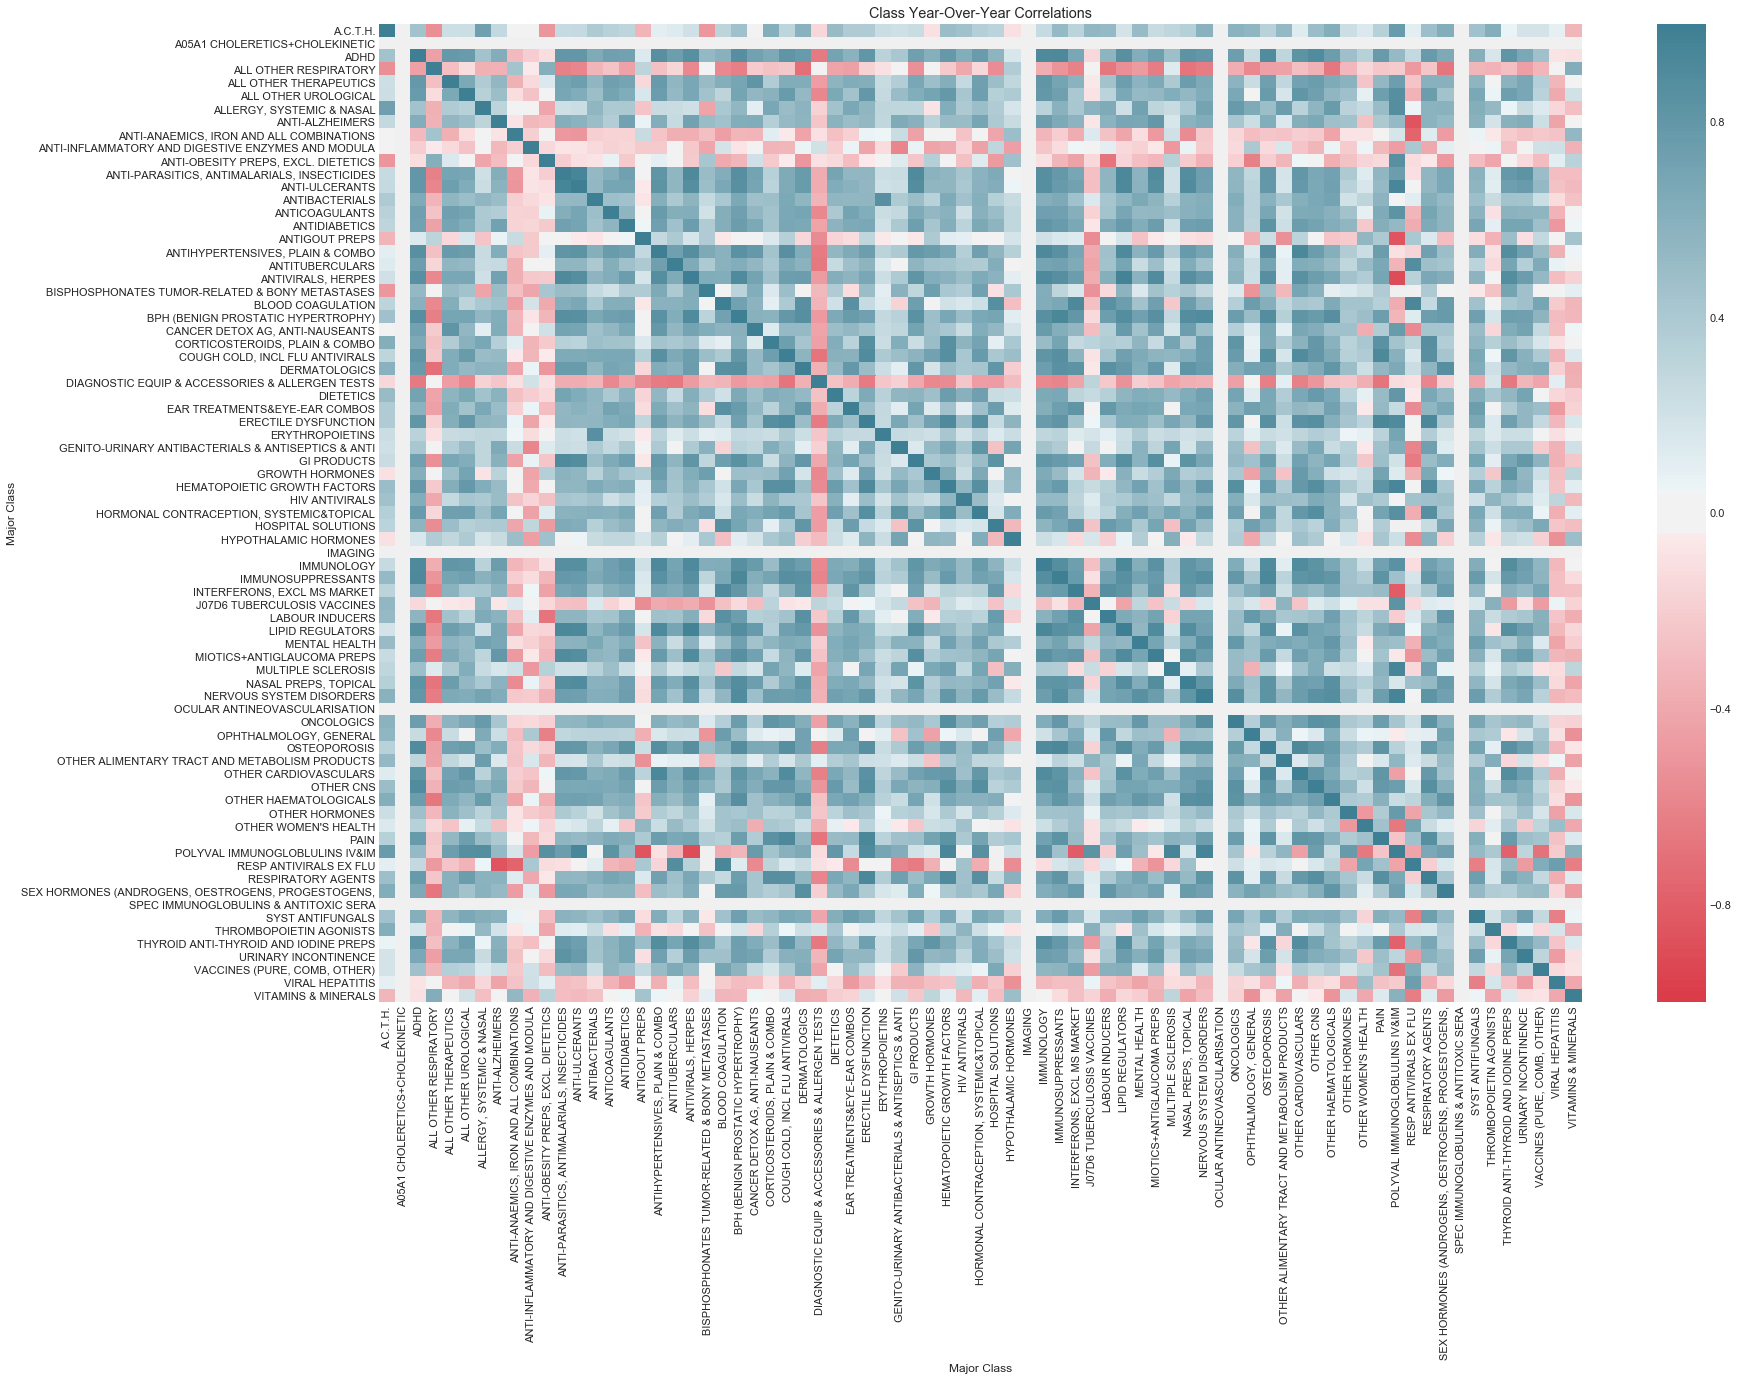

In [23]:
# Correlation matrix
plt.subplots(figsize=(24,18))
sns.heatmap(yy_class_corr, annot=False, cmap=sns.diverging_palette(10, 220, as_cmap=True), vmin = -1, vmax = 1, center = 0)
plt.savefig('Class Year-Over-Year Correlations.jpg', bbox_inches='tight', pad_inches=2)
plt.title('Class Year-Over-Year Correlations')
plt.show()